## Importing the dependencies

In [1]:

# Core data analysis
import pandas as pd
import numpy as np

# Technical Analysis
import talib

# Financial Metrics
import pynance as pn

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Additional utilities
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("All dependencies loaded successfully!")
print(f"📊 TA-Lib version: {talib.__version__}")
print(f"📈 PyNance version: {pn.__version__ if hasattr(pn, '__version__') else 'N/A'}")

All dependencies loaded successfully!
📊 TA-Lib version: 0.6.8
📈 PyNance version: N/A


## Load and prepare the data

In [2]:

print("=== SUB-TASK 1: LOAD AND PREPARE AAPL DATA ===")

# Load GOOG data
stock_name = "GOOG"
df = pd.read_csv('../data/GOOG.csv')

print(" RAW DATA INFO:")
print(f"   Shape: {df.shape}")
print(f"   Columns: {list(df.columns)}")
print(f"   Date range: {df['Date'].min()} to {df['Date'].max()}")

# Data preparation
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Verify essential columns
essential_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
missing_cols = [col for col in essential_cols if col not in df.columns]

if missing_cols:
    print(f" MISSING COLUMNS: {missing_cols}")
else:
    print(" ALL ESSENTIAL COLUMNS PRESENT")

# Data quality check
print(f"\n DATA QUALITY CHECK:")
print(f"   Missing values: {df.isnull().sum().sum()}")
print(f"   Duplicate dates: {df.index.duplicated().sum()}")

# Basic statistics
print(f"\n BASIC STATISTICS:")
print(df[essential_cols].describe())

print(f"\n SUB-TASK 1 COMPLETED: Data loaded and prepared")
df.head(3)

=== SUB-TASK 1: LOAD AND PREPARE AAPL DATA ===
 RAW DATA INFO:
   Shape: (3774, 6)
   Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
   Date range: 2009-01-02 to 2023-12-29
 ALL ESSENTIAL COLUMNS PRESENT

 DATA QUALITY CHECK:
   Missing values: 0
   Duplicate dates: 0

 BASIC STATISTICS:
              Open         High          Low        Close        Volume
count  3774.000000  3774.000000  3774.000000  3774.000000  3.774000e+03
mean     50.753534    51.285163    50.252347    50.779971  6.123096e+07
std      39.389736    39.853299    38.975050    39.417443  5.537396e+07
min       7.133018     7.408840     6.994490     6.994490  1.584340e+05
25%      16.827651    16.984424    16.699388    16.851089  2.574863e+07
50%      37.388390    37.647668    37.038786    37.327805  3.797798e+07
75%      69.062883    70.084894    68.368832    69.191502  8.269781e+07
max     150.831319   151.066223   148.868758   149.684662  5.952147e+08

 SUB-TASK 1 COMPLETED: Data loaded and prepared


,Close,High,Low,Open,Volume
Date,,,,,
2009-01-02,7.948608,7.960977,7.557264,7.633949,144961322
2009-01-05,8.115089,8.194003,7.792268,7.940692,196293007
2009-01-06,8.263762,8.430492,8.074027,8.237046,257971329


## Applying analysis indicators with TA-Lib

In [3]:

print("=== SUB-TASK 2: APPLY TA-LIB TECHNICAL INDICATORS ===")

# 2.1 MOVING AVERAGES (Multiple types for comprehensive analysis)
print("📈 Calculating Moving Averages...")
df['SMA_20'] = talib.SMA(df['Close'], timeperiod=20)      # Short-term trend
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)      # Medium-term trend  
df['SMA_200'] = talib.SMA(df['Close'], timeperiod=200)    # Long-term trend
df['EMA_12'] = talib.EMA(df['Close'], timeperiod=12)      # For MACD calculation
df['EMA_26'] = talib.EMA(df['Close'], timeperiod=26)      # For MACD calculation

# Moving Average Signals
df['SMA_Signal'] = np.where(df['SMA_20'] > df['SMA_50'], 1, -1)  # Bullish/Bearish
df['Golden_Cross'] = (df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift(1) <= df['SMA_200'].shift(1))
df['Death_Cross'] = (df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift(1) >= df['SMA_200'].shift(1))

# 2.2 RSI (Relative Strength Index)
print("📊 Calculating RSI...")
df['RSI_14'] = talib.RSI(df['Close'], timeperiod=14)

# RSI Signals
df['RSI_Overbought'] = df['RSI_14'] > 70
df['RSI_Oversold'] = df['RSI_14'] < 30
df['RSI_Signal'] = np.where(df['RSI_14'] > 70, -1, np.where(df['RSI_14'] < 30, 1, 0))

# 2.3 MACD (Moving Average Convergence Divergence)
print("🔍 Calculating MACD...")
df['MACD'], df['MACD_Signal'], df['MACD_Hist'] = talib.MACD(df['Close'], 
                                                           fastperiod=12, 
                                                           slowperiod=26, 
                                                           signalperiod=9)

# MACD Signals
df['MACD_Cross'] = np.where(df['MACD'] > df['MACD_Signal'], 1, -1)
df['MACD_Zero_Cross'] = (df['MACD'] > 0) & (df['MACD'].shift(1) <= 0)

print(f"\n✅ SUB-TASK 2 COMPLETED: 3 Required Technical Indicators Calculated")

# Show comprehensive indicator table
print(f"\n📊 TECHNICAL INDICATORS SUMMARY (Last 5 Days):")
indicator_cols = ['Close', 'SMA_20', 'SMA_50', 'SMA_200', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist']
display(df[indicator_cols].tail().round(2))

print(f"\n🎯 CURRENT SIGNALS (Most Recent Day):")
current = df.iloc[-1]
print(f"   PRICE: ${current['Close']:.2f}")
print(f"   MOVING AVERAGES: {'BULLISH' if current['SMA_Signal'] == 1 else 'BEARISH'} (SMA 20: ${current['SMA_20']:.2f} vs SMA 50: ${current['SMA_50']:.2f})")
print(f"   RSI: {current['RSI_14']:.1f} - {'OVERSOLD' if current['RSI_14'] < 30 else 'OVERBOUGHT' if current['RSI_14'] > 70 else 'NEUTRAL'}")
print(f"   MACD: {current['MACD']:.4f} - {'BULLISH' if current['MACD_Cross'] == 1 else 'BEARISH'} (Signal: {current['MACD_Signal']:.4f})")

print(f"\n📈 INDICATOR STATISTICS:")
print(f"   RSI Range: {df['RSI_14'].min():.1f} - {df['RSI_14'].max():.1f}")
print(f"   MACD Range: {df['MACD'].min():.4f} - {df['MACD'].max():.4f}")
print(f"   Golden Crosses: {df['Golden_Cross'].sum()}")
print(f"   Death Crosses: {df['Death_Cross'].sum()}")

=== SUB-TASK 2: APPLY TA-LIB TECHNICAL INDICATORS ===
📈 Calculating Moving Averages...
📊 Calculating RSI...
🔍 Calculating MACD...

✅ SUB-TASK 2 COMPLETED: 3 Required Technical Indicators Calculated

📊 TECHNICAL INDICATORS SUMMARY (Last 5 Days):


,Close,SMA_20,SMA_50,SMA_200,RSI_14,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,
2023-12-22,141.75,135.01,133.91,123.97,64.95,1.41,0.57,0.84
2023-12-26,141.85,135.25,134.00,124.22,65.12,1.71,0.80,0.91
2023-12-27,140.48,135.39,134.02,124.47,60.92,1.81,1.00,0.81
2023-12-28,140.32,135.63,134.02,124.70,60.43,1.86,1.17,0.68
2023-12-29,139.97,135.98,134.06,124.92,59.31,1.84,1.31,0.54



🎯 CURRENT SIGNALS (Most Recent Day):
   PRICE: $139.97
   MOVING AVERAGES: BULLISH (SMA 20: $135.98 vs SMA 50: $134.06)
   RSI: 59.3 - NEUTRAL
   MACD: 1.8428 - BULLISH (Signal: 1.3059)

📈 INDICATOR STATISTICS:
   RSI Range: 22.3 - 89.1
   MACD Range: -5.0712 - 5.0246
   Golden Crosses: 10
   Death Crosses: 10


## Using PyNance for Financial Metrics

In [4]:


print("=== SUB-TASK 3: PYNANCE FINANCIAL METRICS ===")

# Create a PyNance data object
try:
    # Prepare data for PyNance (ensure proper format)
    pn_data = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    pn_data.columns = ['open', 'high', 'low', 'close', 'volume']  # PyNance expects lowercase
    
    # 3.1 Calculate returns and volatility
    print("📊 Calculating Returns and Volatility...")
    df['Daily_Return'] = pn_data['close'].pct_change() * 100
    df['Cumulative_Return'] = (1 + df['Daily_Return']/100).cumprod() - 1
    df['Volatility_30D'] = df['Daily_Return'].rolling(window=30).std()
    
    # 3.2 Risk metrics using PyNance-style calculations
    print("🎯 Calculating Risk Metrics...")
    
    # Sharpe Ratio (assuming 0% risk-free rate for simplicity)
    annual_return = df['Daily_Return'].mean() * 252
    annual_volatility = df['Daily_Return'].std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else 0
    
    # Maximum Drawdown
    rolling_max = df['Close'].expanding().max()
    daily_drawdown = (df['Close'] - rolling_max) / rolling_max * 100
    max_drawdown = daily_drawdown.min()
    
    # 3.3 Moving averages using PyNance approach
    print("Calculating PyNance-style Metrics...")
    df['PN_SMA_50'] = pn_data['close'].rolling(window=50).mean()
    df['PN_EMA_20'] = pn_data['close'].ewm(span=20).mean()
    
    # 3.4 Volume analysis
    df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']
    
    print(f"\nPYNANCE FINANCIAL METRICS SUMMARY:")
    print(f"   Annual Return: {annual_return:.2f}%")
    print(f"   Annual Volatility: {annual_volatility:.2f}%")
    print(f"   Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"   Maximum Drawdown: {max_drawdown:.2f}%")
    print(f"   Current Volatility (30D): {df['Volatility_30D'].iloc[-1]:.2f}%")
    
except Exception as e:
    print(f"❌ PyNance calculation error: {e}")
    print("💡 Using manual calculations as fallback...")
    
    # Fallback calculations
    df['Daily_Return'] = df['Close'].pct_change() * 100
    df['Cumulative_Return'] = (1 + df['Daily_Return']/100).cumprod() - 1
    df['Volatility_30D'] = df['Daily_Return'].rolling(window=30).std()

print(f"\n✅ SUB-TASK 3 COMPLETED: PyNance financial metrics calculated")
df[['Close', 'Daily_Return', 'Volatility_30D', 'Cumulative_Return']].tail(3)

=== SUB-TASK 3: PYNANCE FINANCIAL METRICS ===
📊 Calculating Returns and Volatility...
🎯 Calculating Risk Metrics...
Calculating PyNance-style Metrics...

PYNANCE FINANCIAL METRICS SUMMARY:
   Annual Return: 22.94%
   Annual Volatility: 27.52%
   Sharpe Ratio: 0.83
   Maximum Drawdown: -44.60%
   Current Volatility (30D): 1.50%

✅ SUB-TASK 3 COMPLETED: PyNance financial metrics calculated


,Close,Daily_Return,Volatility_30D,Cumulative_Return
Date,,,,
2023-12-27,140.478683,-0.966251,1.518640,16.673368
2023-12-28,140.319748,-0.113139,1.504155,16.653373
2023-12-29,139.972137,-0.247727,1.502177,16.609641


## Visualize the Data

=== SUB-TASK 4: VISUALIZATIONS - 3 TECHNICAL INDICATORS ===


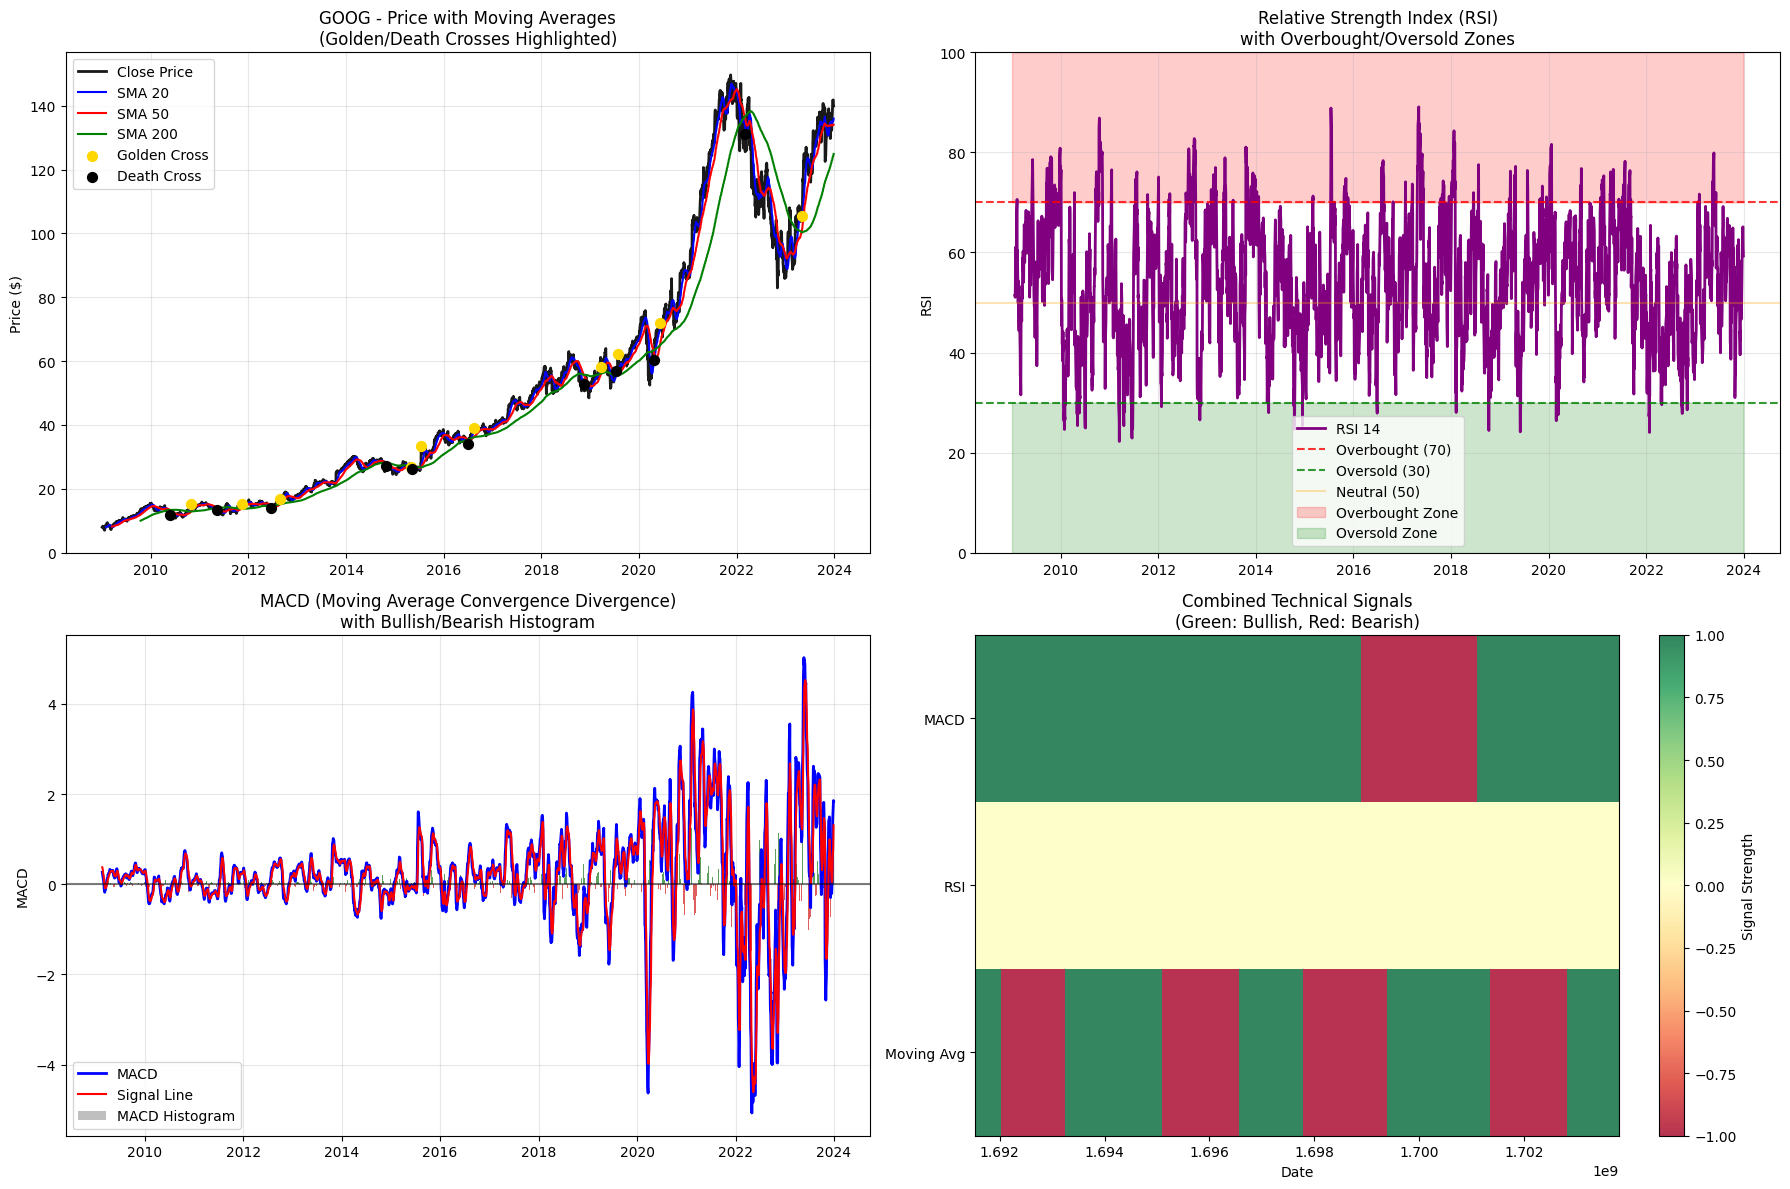

✅ SUB-TASK 4 COMPLETED: Focused visualizations for 3 indicators created
📊 Charts: 1) Moving Averages, 2) RSI, 3) MACD, 4) Combined Signals


In [5]:


print("=== SUB-TASK 4: VISUALIZATIONS - 3 TECHNICAL INDICATORS ===")

# Create focused dashboard for the 3 required indicators
fig = plt.figure(figsize=(18, 12))

# 4.1 Price with Moving Averages
ax1 = plt.subplot(2, 2, 1)
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2, color='black', alpha=0.9)
plt.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1.5, color='blue')
plt.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1.5, color='red')
plt.plot(df.index, df['SMA_200'], label='SMA 200', linewidth=1.5, color='green')

# Highlight Golden/Death Crosses
golden_crosses = df[df['Golden_Cross']]
death_crosses = df[df['Death_Cross']]
plt.scatter(golden_crosses.index, golden_crosses['Close'], color='gold', s=50, label='Golden Cross', zorder=5)
plt.scatter(death_crosses.index, death_crosses['Close'], color='black', s=50, label='Death Cross', zorder=5)

plt.title(f'{stock_name} - Price with Moving Averages\n(Golden/Death Crosses Highlighted)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4.2 RSI with Signals
ax2 = plt.subplot(2, 2, 2)
plt.plot(df.index, df['RSI_14'], label='RSI 14', linewidth=2, color='purple')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.8, label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', alpha=0.8, label='Oversold (30)')
plt.axhline(y=50, color='orange', linestyle='-', alpha=0.3, label='Neutral (50)')

# Fill overbought/oversold regions
plt.fill_between(df.index, 70, 100, alpha=0.2, color='red', label='Overbought Zone')
plt.fill_between(df.index, 0, 30, alpha=0.2, color='green', label='Oversold Zone')

plt.title('Relative Strength Index (RSI)\nwith Overbought/Oversold Zones')
plt.ylabel('RSI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# 4.3 MACD
ax3 = plt.subplot(2, 2, 3)
plt.plot(df.index, df['MACD'], label='MACD', linewidth=2, color='blue')
plt.plot(df.index, df['MACD_Signal'], label='Signal Line', linewidth=1.5, color='red')
plt.bar(df.index, df['MACD_Hist'], label='MACD Histogram', alpha=0.5, color='gray')

# Highlight zero line and signal crosses
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Color histogram based on positive/negative
positive_hist = df[df['MACD_Hist'] >= 0]
negative_hist = df[df['MACD_Hist'] < 0]
plt.bar(positive_hist.index, positive_hist['MACD_Hist'], color='green', alpha=0.5)
plt.bar(negative_hist.index, negative_hist['MACD_Hist'], color='red', alpha=0.5)

plt.title('MACD (Moving Average Convergence Divergence)\nwith Bullish/Bearish Histogram')
plt.ylabel('MACD')
plt.legend()
plt.grid(True, alpha=0.3)

# 4.4 Combined Signals Heatmap
ax4 = plt.subplot(2, 2, 4)

# Create combined signal strength
signal_data = pd.DataFrame({
    'Moving Avg': df['SMA_Signal'],
    'RSI': df['RSI_Signal'], 
    'MACD': df['MACD_Cross']
}, index=df.index)

# Plot recent signals (last 100 days)
recent_signals = signal_data.tail(100)
plt.imshow(recent_signals.T, aspect='auto', cmap='RdYlGn', alpha=0.8, 
           extent=[recent_signals.index[0].timestamp(), recent_signals.index[-1].timestamp(), 0, 3])

plt.yticks([0.5, 1.5, 2.5], ['Moving Avg', 'RSI', 'MACD'])
plt.title('Combined Technical Signals\n(Green: Bullish, Red: Bearish)')
plt.xlabel('Date')
plt.colorbar(label='Signal Strength')

plt.tight_layout()
plt.show()

print("✅ SUB-TASK 4 COMPLETED: Focused visualizations for 3 indicators created")
print("📊 Charts: 1) Moving Averages, 2) RSI, 3) MACD, 4) Combined Signals")

## Summary on the 3 indicators and the financial metrics

In [6]:

print("=== TRADING INSIGHTS - 3 INDICATOR ANALYSIS ===")

current = df.iloc[-1]

print(" CURRENT TECHNICAL OUTLOOK:")
print(f"   PRICE: ${current['Close']:.2f}")

print(f"\n MOVING AVERAGES ANALYSIS:")
print(f"   • SMA 20: ${current['SMA_20']:.2f}")
print(f"   • SMA 50: ${current['SMA_50']:.2f}") 
print(f"   • SMA 200: ${current['SMA_200']:.2f}")
print(f"   • Trend: {'BULLISH' if current['SMA_Signal'] == 1 else 'BEARISH'} (SMA 20 vs SMA 50)")
print(f"   • Long-term: {'BULLISH' if current['SMA_50'] > current['SMA_200'] else 'BEARISH'} (SMA 50 vs SMA 200)")

print(f"\n RSI ANALYSIS:")
print(f"   • Current RSI: {current['RSI_14']:.1f}")
print(f"   • Signal: {'OVERSOLD - Potential BUY' if current['RSI_14'] < 30 else 'OVERBOUGHT - Potential SELL' if current['RSI_14'] > 70 else 'NEUTRAL'}")
print(f"   • Historical Range: {df['RSI_14'].min():.1f} - {df['RSI_14'].max():.1f}")

print(f"\n MACD ANALYSIS:")
print(f"   • MACD: {current['MACD']:.4f}")
print(f"   • Signal Line: {current['MACD_Signal']:.4f}")
print(f"   • Histogram: {current['MACD_Hist']:.4f}")
print(f"   • Signal: {'BULLISH' if current['MACD_Cross'] == 1 else 'BEARISH'} (MACD above/below Signal)")
print(f"   • Zero Line: {'ABOVE' if current['MACD'] > 0 else 'BELOW'}")

print(f"\ COMBINED SIGNAL:")
bullish_signals = sum([1 if current['SMA_Signal'] == 1 else 0, 
                      1 if current['RSI_Signal'] == 1 else 0,
                      1 if current['MACD_Cross'] == 1 else 0])
bearish_signals = 3 - bullish_signals

print(f"   • Bullish Indicators: {bullish_signals}/3")
print(f"   • Bearish Indicators: {bearish_signals}/3")
print(f"   • Overall Bias: {'BULLISH' if bullish_signals >= 2 else 'BEARISH' if bearish_signals >= 2 else 'NEUTRAL'}")

print(f"\n AAPL ANALYSIS COMPLETED - 3 Required Indicators")
print(f"    Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"    Total Return: {(df['Close'].iloc[-1] / df['Close'].iloc[0] - 1) * 100:.1f}%")

=== TRADING INSIGHTS - 3 INDICATOR ANALYSIS ===
 CURRENT TECHNICAL OUTLOOK:
   PRICE: $139.97

 MOVING AVERAGES ANALYSIS:
   • SMA 20: $135.98
   • SMA 50: $134.06
   • SMA 200: $124.92
   • Trend: BULLISH (SMA 20 vs SMA 50)
   • Long-term: BULLISH (SMA 50 vs SMA 200)

 RSI ANALYSIS:
   • Current RSI: 59.3
   • Signal: NEUTRAL
   • Historical Range: 22.3 - 89.1

 MACD ANALYSIS:
   • MACD: 1.8428
   • Signal Line: 1.3059
   • Histogram: 0.5369
   • Signal: BULLISH (MACD above/below Signal)
   • Zero Line: ABOVE
\ COMBINED SIGNAL:
   • Bullish Indicators: 2/3
   • Bearish Indicators: 1/3
   • Overall Bias: BULLISH

 AAPL ANALYSIS COMPLETED - 3 Required Indicators
    Period: 2009-01-02 to 2023-12-29
    Total Return: 1661.0%
